<a href="https://colab.research.google.com/github/ahmedelraei/stock-prices-predict/blob/main/Stock_Prices_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas_datareader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


# Pre-processing Data

In [29]:
ticker = "GOOG"

start = dt.datetime(2008,1,1)
end = dt.datetime(2022,1,1)

data = pandas_datareader.DataReader(ticker, "yahoo", start, end)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-27,148.426498,147.250000,147.463501,148.063995,13256000.0,148.063995
2021-12-28,148.374496,145.935501,148.374496,146.447998,18624000.0,146.447998
2021-12-29,147.183746,145.504501,146.429504,146.504501,17022000.0,146.504501
2021-12-30,147.062500,145.758499,146.449997,146.002502,12978000.0,146.002502
2021-12-31,146.365005,144.677505,145.544006,144.679504,17298000.0,144.679504


# Training Model

In [30]:
prediction_days = 90

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
108/108 [==============================] - 21s 132ms/step - loss: 0.0059
Epoch 2/25
108/108 [==============================] - 13s 121ms/step - loss: 0.0014
Epoch 3/25
108/108 [==============================] - 14s 130ms/step - loss: 0.0012
Epoch 4/25
108/108 [==============================] - 13s 120ms/step - loss: 0.0011
Epoch 5/25
108/108 [==============================] - 13s 121ms/step - loss: 0.0012
Epoch 6/25
108/108 [==============================] - 14s 132ms/step - loss: 0.0010
Epoch 7/25
108/108 [==============================] - 13s 122ms/step - loss: 8.8861e-04
Epoch 8/25
108/108 [==============================] - 13s 120ms/step - loss: 8.5864e-04
Epoch 9/25
108/108 [==============================] - 14s 132ms/step - loss: 8.8366e-04
Epoch 10/25
108/108 [==============================] - 13s 120ms/step - loss: 7.4077e-04
Epoch 11/25
108/108 [==============================] - 13s 120ms/step - loss: 7.6805e-04
Epoch 12/25
108/108 [==============================] -

# Testing The Model

In [31]:
test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()
test_data = pandas_datareader.DataReader(ticker, "yahoo", test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs) + 1):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

7/7 [==============================] - 2s 33ms/step


# Predicting Next Day

In [37]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = scaler.inverse_transform(model.predict(real_data))
prediction[0][0]

1/1 [==============================] - 0s 33ms/step


93.82826

# Plotting The Results

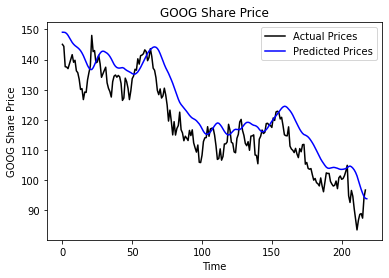

In [38]:
plt.plot(actual_prices, color="black", label="Actual Prices")
plt.plot(predicted_prices, color="blue", label="Predicted Prices")
plt.title(f"{ticker} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Share Price")
plt.legend()
plt.show()